## UIDAI Data Hackathon - Biometric Dataset 

In [2]:
import pandas as pd 
import numpy as np

In [3]:
import zipfile
import os
import pandas as pd

zip_path = "C:/Users/agast/Downloads/api_data_aadhar_biometric.zip"
extract_path = "C:/Users/agast/Downloads/api_data_aadhar_biometric"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

biometric_files = []

for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith(".csv"):
            biometric_files.append(os.path.join(root, file))

print("CSV files found:", len(biometric_files))

biometric_dfs = [pd.read_csv(f) for f in biometric_files]
biometric = pd.concat(biometric_dfs, ignore_index=True)

biometric.head()


CSV files found: 4


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815


In [4]:
biometric = pd.concat(biometric_dfs, ignore_index=True)
print(biometric.shape)


(1861108, 6)


In [5]:
import re 

def clean_text(text):
    if pd.isna(text):
        return np.nan

    text = str(text).lower().strip()

    # to remove special characters 
    text = re.sub(r'[^\W\S]','',text)

    # to remove extra spaces
    text = re.sub(r'\s+','',text)

    return text

In [6]:
biometric['state_clean'] = biometric['state'].apply(clean_text)
biometric['district_clean'] = biometric['district'].apply(clean_text)

In [7]:
noise_words = ['district','dist','dt']

def remove_noise(text):
    if pd.isna(text):
        return text
    for w in noise_words:
        text = text.replace(w, '')
    return text.strip()

biometric['district_clean'] = biometric['district_clean'].apply(remove_noise)

In [8]:
from difflib import get_close_matches

unique_states = biometric['state_clean'].dropna().unique().tolist()

state_map = {}

for state in unique_states:
    matches = get_close_matches(state, unique_states, cutoff=0.9)
    canonical = min(matches)
    for m in matches:
        state_map[m] = canonical

biometric['state_final'] = biometric['state_clean'].map(state_map)

In [9]:
biometric['district_final'] = biometric['district_clean']

In [10]:
biometric['date'] = pd.to_datetime(
    biometric['date'],
    dayfirst=True,
    errors='coerce'
)

biometric = biometric.dropna(subset=['date'])


In [11]:
bio_cols = ['bio_age_5_17','bio_age_17_']
biometric[bio_cols] = biometric[bio_cols].fillna(0)
biometric[bio_cols] = biometric[bio_cols].clip(lower=0)

In [12]:
print("Before Cleaning:", biometric['state'].nunique())
print("After Cleaning:",biometric['state_final'].nunique())

biometric['state_final'].value_counts().head(20)

Before Cleaning: 57
After Cleaning: 44


state_final
tamilnadu          184569
andhrapradesh      172065
uttarpradesh       155242
maharashtra        151104
karnataka          141227
westbangal         130895
kerala              98511
gujarat             89531
odisha              86521
bihar               83398
telangana           82579
rajasthan           79724
madhyapradesh       70080
punjab              48108
assam               47643
jharkhand           36625
chhatisgarh         31997
himachalpradesh     30385
haryana             26429
uttarakhand         22599
Name: count, dtype: int64

In [13]:
official_states = [
    "andaman and nicobar islands",
    "andhra pradesh",
    "arunachal pradesh",
    "assam",
    "bihar",
    "chandigarh",
    "chhattisgarh",
    "dadra and nagar haveli and daman and diu",
    "delhi",
    "goa",
    "gujarat",
    "haryana",
    "himachal pradesh",
    "jammu and kashmir",
    "jharkhand",
    "karnataka",
    "kerala",
    "ladakh",
    "lakshadweep",
    "madhya pradesh",
    "maharashtra",
    "manipur",
    "meghalaya",
    "mizoram",
    "nagaland",
    "odisha",
    "puducherry",
    "punjab",
    "rajasthan",
    "sikkim",
    "tamil nadu",
    "telangana",
    "tripura",
    "uttar pradesh",
    "uttarakhand",
    "west bengal"
]


In [14]:
official_states_clean = [s.replace(" ", "") for s in official_states]

In [15]:
from difflib import get_close_matches

def map_to_official(state):
    if pd.isna(state):
        return np.nan

    matches = get_close_matches(
        state,
        official_states_clean,
        n=1,
        cutoff=0.75
    )

    if matches:
        return official_states[official_states_clean.index(matches[0])]
    else:
        return "unknown"

In [16]:
biometric['state_final'] = biometric['state_final'].apply(
    lambda x: x.replace(" ", "") if isinstance(x, str) else x
)

biometric['state_final'] = biometric['state_final'].apply(map_to_official)

In [17]:
print("Final unique states:", biometric['state_final'].nunique())
biometric['state_final'].value_counts()

Final unique states: 37


state_final
tamil nadu                                  184569
andhra pradesh                              172065
uttar pradesh                               155242
maharashtra                                 151104
karnataka                                   141227
west bengal                                 130895
kerala                                       98511
gujarat                                      89531
odisha                                       86521
bihar                                        83398
telangana                                    82579
rajasthan                                    79724
madhya pradesh                               70080
punjab                                       48108
assam                                        47643
jharkhand                                    36625
chhattisgarh                                 31997
himachal pradesh                             30385
haryana                                      26429
uttarakhand        

In [18]:
biometric.loc[
    biometric['state_final'] == 'unknown',
    'state'
].value_counts()


state
Orissa                    13153
Daman and Diu               412
Dadra and Nagar Haveli      325
Daman & Diu                 264
Dadra & Nagar Haveli        100
Uttaranchal                   2
Name: count, dtype: int64

In [19]:
biometric.loc[
    biometric['state_final'] == 'unknown',
    ['state', 'state_final']
].value_counts().head(20)


state                   state_final
Orissa                  unknown        13153
Daman and Diu           unknown          412
Dadra and Nagar Haveli  unknown          325
Daman & Diu             unknown          264
Dadra & Nagar Haveli    unknown          100
Uttaranchal             unknown            2
Name: count, dtype: int64

In [20]:
import re
import numpy as np

biometric['state_base'] = (
    biometric['state']
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace(r'[^\w\s]', '', regex=True)  # remove & . -
    .str.replace(' ', '', regex=False)        # remove spaces
)


In [21]:
biometric[['state', 'state_base']].head(10)


,state,state_base
0,Haryana,haryana
1,Bihar,bihar
2,Jammu and Kashmir,jammuandkashmir
3,Bihar,bihar
4,Tamil Nadu,tamilnadu
5,Maharashtra,maharashtra
6,Gujarat,gujarat
7,Gujarat,gujarat
8,Odisha,odisha
9,Gujarat,gujarat


In [22]:
historical_state_map = {
    'orissa': 'odisha',
    'uttaranchal': 'uttarakhand',

    'damananddiu': 'dadraandnagarhavelianddamananddiu',
    'daman diu': 'dadraandnagarhavelianddamananddiu',
    'damanand diu': 'dadraandnagarhavelianddamananddiu',

    'dadraandnagarhaveli': 'dadraandnagarhavelianddamananddiu',
    'dadra nagar haveli': 'dadraandnagarhavelianddamananddiu'
}

biometric['state_base'] = biometric['state_base'].replace(historical_state_map)


In [23]:
biometric['state_final'] = biometric['state_base'].apply(map_to_official)


In [24]:
print("Final unique states:", biometric['state_final'].nunique())
biometric['state_final'].value_counts()


Final unique states: 37


state_final
tamil nadu                                  184569
andhra pradesh                              172065
uttar pradesh                               155242
maharashtra                                 151104
karnataka                                   141227
west bengal                                 130895
odisha                                       99674
kerala                                       98511
gujarat                                      89531
bihar                                        83398
telangana                                    82579
rajasthan                                    79724
madhya pradesh                               70080
punjab                                       48108
assam                                        47643
jharkhand                                    36625
chhattisgarh                                 31997
himachal pradesh                             30385
haryana                                      26429
uttarakhand        

In [25]:
biometric.loc[
    biometric['state_final'] == 'unknown',
    'state'
].value_counts()


state
Daman & Diu             264
Dadra & Nagar Haveli    100
Name: count, dtype: int64

In [26]:
biometric.loc[
    biometric['state_final'] == 'unknown',
    ['state', 'state_base']
].value_counts()


state                 state_base      
Daman & Diu           damandiu            264
Dadra & Nagar Haveli  dadranagarhaveli    100
Name: count, dtype: int64

In [28]:
final_merge_fix = {
    'damandiu': 'dadraandnagarhavelianddamananddiu',
    'dadranagarhaveli': 'dadraandnagarhavelianddamananddiu'
}

biometric['state_base'] = biometric['state_base'].replace(final_merge_fix)


In [29]:
biometric['state_final'] = biometric['state_base'].apply(map_to_official)


In [30]:
print("Final unique states:", biometric['state_final'].nunique())
biometric['state_final'].value_counts()


Final unique states: 36


state_final
tamil nadu                                  184569
andhra pradesh                              172065
uttar pradesh                               155242
maharashtra                                 151104
karnataka                                   141227
west bengal                                 130895
odisha                                       99674
kerala                                       98511
gujarat                                      89531
bihar                                        83398
telangana                                    82579
rajasthan                                    79724
madhya pradesh                               70080
punjab                                       48108
assam                                        47643
jharkhand                                    36625
chhattisgarh                                 31997
himachal pradesh                             30385
haryana                                      26429
uttarakhand        

In [31]:
import re

biometric['district_base'] = (
    biometric['district']
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace(r'[^\w\s]', ' ', regex=True)   # remove special chars
    .str.replace(r'\s+', ' ', regex=True)       # remove extra spaces
)


In [32]:
biometric[['district', 'district_base']].head(10)


,district,district_base
0,Mahendragarh,mahendragarh
1,Madhepura,madhepura
2,Punch,punch
3,Bhojpur,bhojpur
4,Madurai,madurai
5,Ratnagiri,ratnagiri
6,Anand,anand
7,Gandhinagar,gandhinagar
8,Dhenkanal,dhenkanal
9,Valsad,valsad


In [33]:
noise_words = [' district', ' dist', ' dt']

def remove_district_noise(text):
    for w in noise_words:
        text = text.replace(w, '')
    return text.strip()

biometric['district_base'] = biometric['district_base'].apply(remove_district_noise)


In [35]:
print("Before cleaning (district count):",
      biometric.groupby('state_final')['district'].nunique().sum())

print("Unique district_base:",
      biometric['district_base'].nunique())


Before cleaning (district count): 996
Unique district_base: 923


In [38]:
from difflib import get_close_matches

def canonicalize_districts(df, cutoff=0.9):
    mapping = {}
    unique_districts = df['district_base'].unique().tolist()

    for d in unique_districts:
        if d in mapping:
            continue

        matches = get_close_matches(d, unique_districts, cutoff=cutoff)
        canonical = min(matches, key=len)  # shortest name as standard

        for m in matches:
            mapping[m] = canonical

    # ✅ FIX: map (not mao)
    return df['district_base'].map(mapping)


In [39]:
biometric['district_final'] = biometric.groupby(
    'state_final', group_keys=False
).apply(canonicalize_districts)


C:\Users\agast\AppData\Local\Temp\ipykernel_25132\174025318.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(canonicalize_districts)


In [40]:
biometric[['state_final', 'district', 'district_base', 'district_final']].head(20)


,state_final,district,district_base,district_final
0,haryana,Mahendragarh,mahendragarh,mahendragarh
1,bihar,Madhepura,madhepura,madhepura
2,jammu and kashmir,Punch,punch,punch
3,bihar,Bhojpur,bhojpur,bhojpur
4,tamil nadu,Madurai,madurai,madurai
5,maharashtra,Ratnagiri,ratnagiri,ratnagiri
6,gujarat,Anand,anand,anand
7,gujarat,Gandhinagar,gandhinagar,gandhinagar
8,odisha,Dhenkanal,dhenkanal,dhenkanal
9,gujarat,Valsad,valsad,valsad


In [41]:
print("After cleaning (unique districts):",
      biometric.groupby('state_final')['district_final'].nunique().sum())


After cleaning (unique districts): 874


In [42]:
biometric[biometric['state_final'] == 'maharashtra'][
    ['district', 'district_final']
].drop_duplicates().head(30)


,district,district_final
5,Ratnagiri,ratnagiri
27,Wardha,wardha
106,Amravati,amravati
117,Dhule,dhule
149,Ahmadnagar,ahmadnagar
156,Nagpur,nagpur
177,Solapur,solapur
192,Kolhapur,kolhapur
234,Chandrapur,chandrapur
266,Nanded,nanded


In [43]:
# Count unknown districts
unknown_districts = biometric['district_final'].value_counts().get('unknown', 0)

total_rows = len(biometric)

print("Unknown district rows:", unknown_districts)
print("Percentage:", round(unknown_districts / total_rows * 100, 4), "%")


Unknown district rows: 0
Percentage: 0.0 %


In [44]:
biometric.loc[
    biometric['district_final'] == 'unknown',
    'district'
].value_counts().head(50)


Series([], Name: count, dtype: int64)

In [45]:
biometric.loc[
    biometric['district_final'] == 'unknown',
    ['district', 'district_base', 'state_final']
].value_counts().head(30)


Series([], Name: count, dtype: int64)

In [46]:
state_district_counts = biometric.groupby('state_final')['district_final'].nunique()

state_district_counts.sort_values(ascending=False)


state_final
uttar pradesh                               80
madhya pradesh                              58
maharashtra                                 44
bihar                                       43
karnataka                                   43
rajasthan                                   43
west bengal                                 41
tamil nadu                                  40
andhra pradesh                              39
assam                                       37
telangana                                   36
chhattisgarh                                36
gujarat                                     35
odisha                                      33
jammu and kashmir                           28
jharkhand                                   27
punjab                                      26
arunachal pradesh                           23
haryana                                     23
nagaland                                    17
kerala                                      14
u

In [47]:
biometric

,date,state,district,pincode,bio_age_5_17,bio_age_17_,state_clean,district_clean,state_final,district_final,state_base,district_base
0,2025-03-01,Haryana,Mahendragarh,123029,280,577,haryana,mahendragarh,haryana,mahendragarh,haryana,mahendragarh
1,2025-03-01,Bihar,Madhepura,852121,144,369,bihar,madhepura,bihar,madhepura,bihar,madhepura
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091,jammuandkashmir,punch,jammu and kashmir,punch,jammuandkashmir,punch
3,2025-03-01,Bihar,Bhojpur,802158,256,980,bihar,bhojpur,bihar,bhojpur,bihar,bhojpur
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815,tamilnadu,madurai,tamil nadu,madurai,tamilnadu,madurai
...,...,...,...,...,...,...,...,...,...,...,...,...
1861103,2025-11-07,Kerala,Ernakulam,682020,1,6,kerala,ernakulam,kerala,ernakulam,kerala,ernakulam
1861104,2025-11-07,Kerala,Ernakulam,682022,1,0,kerala,ernakulam,kerala,ernakulam,kerala,ernakulam
1861105,2025-11-07,Kerala,Ernakulam,682023,0,1,kerala,ernakulam,kerala,ernakulam,kerala,ernakulam
1861106,2025-11-07,Kerala,Ernakulam,682025,3,6,kerala,ernakulam,kerala,ernakulam,kerala,ernakulam


In [48]:
import pandas as pd 
import matplotlib.pyplot as plt 

# Ensuring datetime 
biometric['date'] = pd.to_datetime(biometric['date'], dayfirst=True, errors='coerce')

# Total biometric updates
biometric['total_bio'] = biometric['bio_age_5_17'] + biometric['bio_age_17_']

# Year-Month for trend analysis 
biometric['year_month'] = biometric['date'].dt.to_period('M')

# UNIAVRIATE EDA

In [49]:
biometric['total_bio'].describe()

count    1.861108e+06
mean     3.748471e+01
std      1.623302e+02
min      0.000000e+00
25%      3.000000e+00
50%      8.000000e+00
75%      2.200000e+01
max      1.338100e+04
Name: total_bio, dtype: float64

In [50]:
state_bio = biometric.groupby('state_final')['total_bio'].sum().sort_values(ascending=False)

state_bio.head(10)


state_final
uttar pradesh     9577735
maharashtra       9226139
madhya pradesh    5923771
bihar             4897587
tamil nadu        4698118
rajasthan         3994955
andhra pradesh    3714633
gujarat           3196514
chhattisgarh      2648734
karnataka         2635954
Name: total_bio, dtype: int64

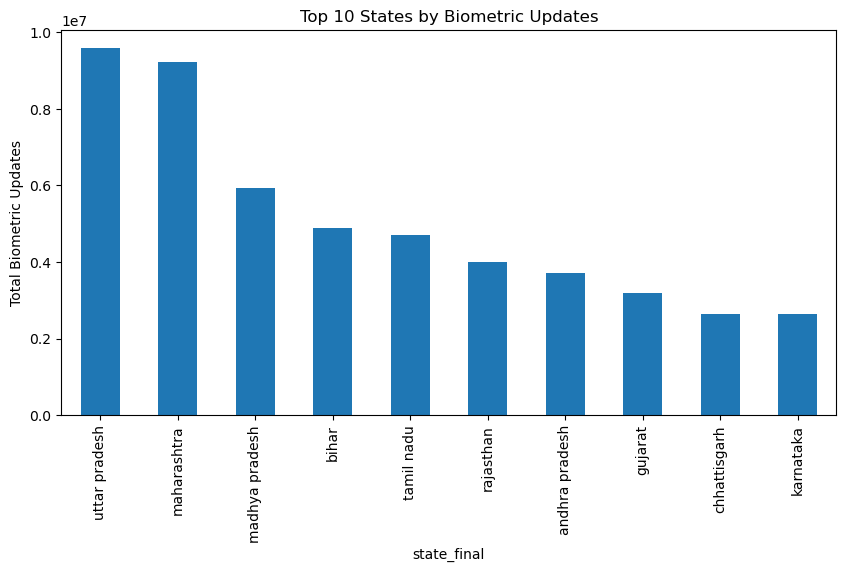

In [51]:
state_bio.head(10).plot(kind='bar', figsize=(10,5),
                        title='Top 10 States by Biometric Updates')
plt.ylabel("Total Biometric Updates")
plt.show()

# BIVARIATE EDA

###  Age Group Comparison

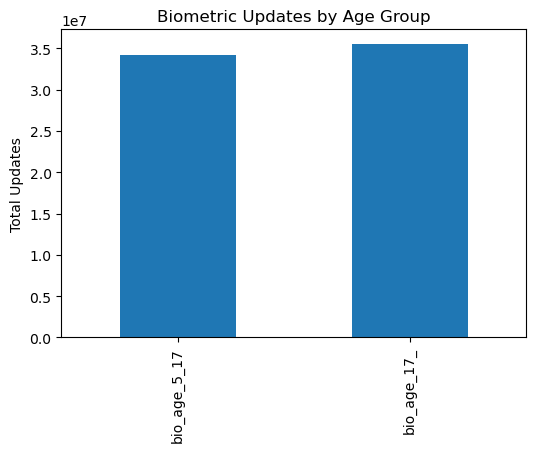

In [52]:
age_compare = biometric[['bio_age_5_17', 'bio_age_17_']].sum()

age_compare.plot(kind='bar', figsize=(6,4),
                 title='Biometric Updates by Age Group')
plt.ylabel("Total Updates")
plt.show()

## Insight
Normally Aadhar Lifecycle must be followed 5-17 Update then again after 17+ Update it should be properly balanced. UIDAI Should use a proper policy correction and must do awareness camps for not just enrolment-based but update-based.

##  Monthly Biometric Trend

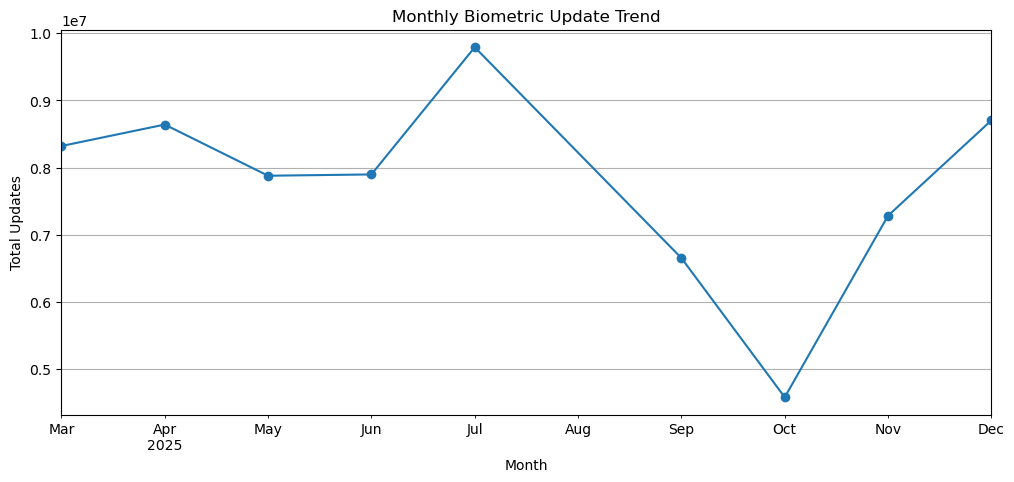

In [54]:
monthly_trend = biometric.groupby('year_month')['total_bio'].sum()

monthly_trend.plot(figsize=(12,5), marker='o',
                   title='Monthly Biometric Update Trend')
plt.xlabel("Month")
plt.ylabel("Total Updates")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Insight
We can see that Biometric Updates are seasonal may be possible reasons are School/College Admissions, Government Deadlines, Exam Cycles. Solution can be Temporary Updation camp through vans and proper seasonal staff allocation.

# TRIVARIATE EDA 

In [55]:
state_month = biometric.groupby(
    ['state_final', 'year_month']
)['total_bio'].sum().reset_index()


In [56]:
volatility = state_month.groupby('state_final')['total_bio'].std() \
                        .sort_values(ascending=False)

volatility.head(10)


state_final
madhya pradesh    250726.396681
uttar pradesh     241002.900714
bihar             177076.076661
maharashtra       167846.324876
rajasthan         161844.799967
gujarat           132903.399425
tamil nadu        121427.605123
chhattisgarh      112409.454058
andhra pradesh    112343.344953
jharkhand          87790.232067
Name: total_bio, dtype: float64

In [57]:
district_daily = biometric.groupby(
    ['state_final', 'district_final', 'date']
)['total_bio'].sum().reset_index()


In [58]:
district_stats = district_daily.groupby(
    ['state_final', 'district_final']
)['total_bio'].agg(['mean','max']).reset_index()

district_stats['spike_ratio'] = district_stats['max'] / (district_stats['mean'] + 1)

district_stats.sort_values('spike_ratio', ascending=False).head(10)


,state_final,district_final,mean,max,spike_ratio
521,mizoram,serchhip,91.614458,4123,44.517887
512,mizoram,champhai,199.600000,7852,39.142572
146,chandigarh,chandigarh,865.837209,32547,37.546842
515,mizoram,kolasib,131.698795,4946,37.272381
511,mizoram,aizawl,433.068966,15783,36.360582
519,mizoram,saiha,71.950000,2617,35.873886
518,mizoram,mamit,171.797468,5972,34.560692
517,mizoram,lunglei,188.753086,5776,30.439558
499,manipur,thoubal,644.172414,19479,30.191929
495,manipur,kakching,25.271605,786,29.918233


In [59]:
from scipy.stats import zscore

district_daily['z_score'] = district_daily.groupby(
    ['state_final','district_final']
)['total_bio'].transform(zscore)

anomalies = district_daily[district_daily['z_score'] > 4]

anomalies.head()


C:\Users\agast\anaconda3\Lib\site-packages\pandas\core\groupby\generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(group, *args, **kwargs)
C:\Users\agast\anaconda3\Lib\site-packages\pandas\core\groupby\generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(group, *args, **kwargs)
C:\Users\agast\anaconda3\Lib\site-packages\pandas\core\groupby\generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(group, *args, **kwargs)
C:\Users\agast\anaconda3\Lib\site-packages\pandas\core\groupby\generic.py:557: RuntimeWarning: Precision loss occurred in moment calculatio

,state_final,district_final,date,total_bio,z_score
0,andaman and nicobar islands,andamans,2025-03-01,209,4.075270
4,andaman and nicobar islands,andamans,2025-07-01,259,5.181938
81,andaman and nicobar islands,nicobar,2025-03-01,279,4.877208
82,andaman and nicobar islands,nicobar,2025-04-01,268,4.666675
85,andaman and nicobar islands,nicobar,2025-07-01,242,4.169053


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")


In [61]:
biometric['total_bio'] = biometric['bio_age_5_17'] + biometric['bio_age_17_']



Column: state_final (Top 10)
state_final
tamil nadu        184569
andhra pradesh    172065
uttar pradesh     155242
maharashtra       151104
karnataka         141227
west bengal       130895
odisha             99674
kerala             98511
gujarat            89531
bihar              83398
Name: count, dtype: int64


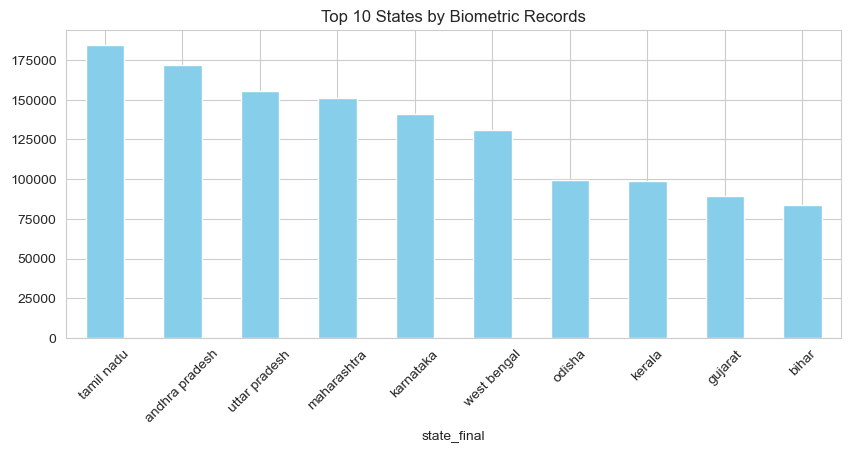

*******************************


In [62]:
print("\nColumn: state_final (Top 10)")

state_counts = biometric['state_final'].value_counts().head(10)
print(state_counts)

plt.figure(figsize=(10,4))
state_counts.plot(kind='bar', color='skyblue')
plt.title("Top 10 States by Biometric Records")
plt.xticks(rotation=45)
plt.show()

print("*******************************")



Column: district_final (Top 15)
district_final
west godavari        19272
bardhaman            14034
viluppuram           13123
anantapur            12470
pune                 11586
thrissur             11165
north 24 parganas    10595
karimnagar           10163
warangal              9976
palakkad              9605
hyderabad             9422
ernakulam             9113
medak                 9020
tirunelveli           9003
khorda                8918
Name: count, dtype: int64


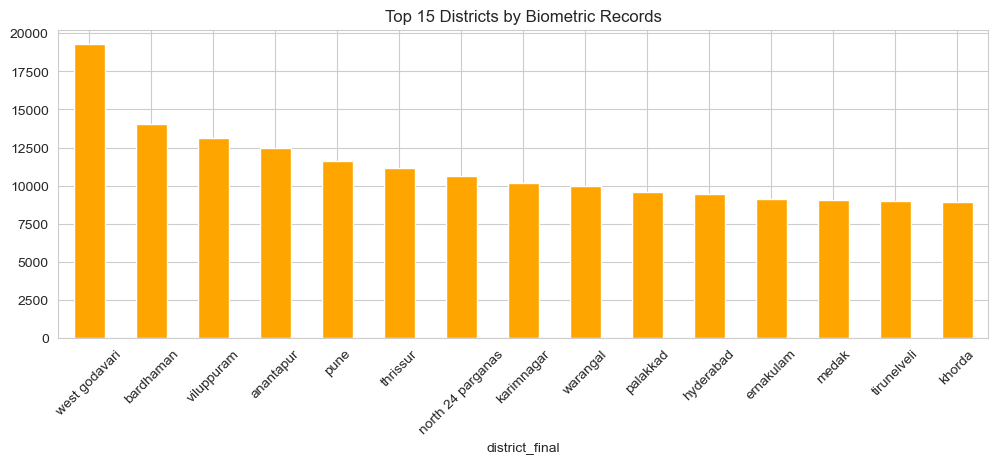

*******************************


In [63]:
print("\nColumn: district_final (Top 15)")

district_counts = biometric['district_final'].value_counts().head(15)
print(district_counts)

plt.figure(figsize=(12,4))
district_counts.plot(kind='bar', color='orange')
plt.title("Top 15 Districts by Biometric Records")
plt.xticks(rotation=45)
plt.show()

print("*******************************")



Distribution of bio_age_5_17


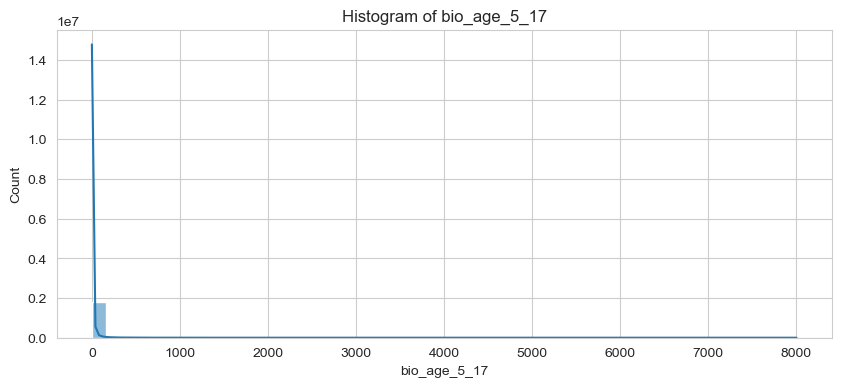

Outliers in bio_age_5_17


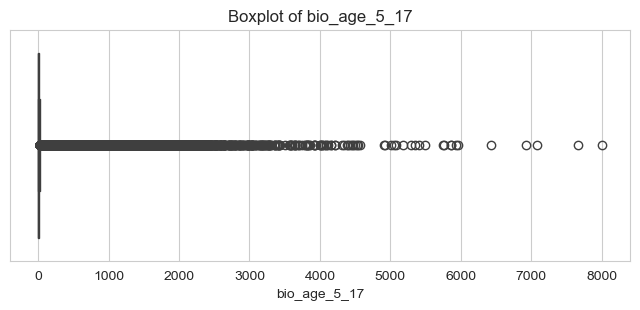

*******************************

Distribution of bio_age_17_


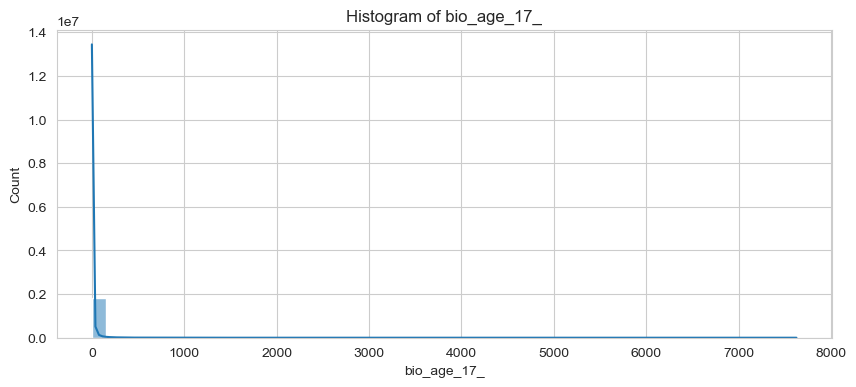

Outliers in bio_age_17_


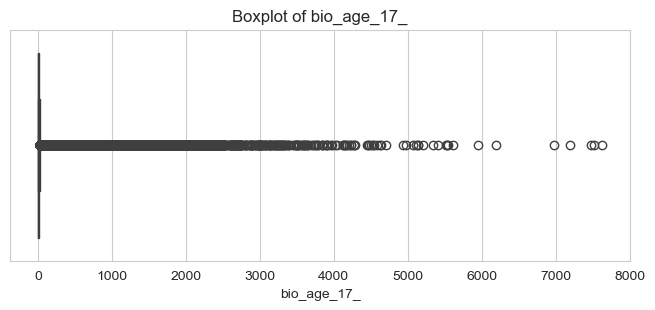

*******************************

Distribution of total_bio


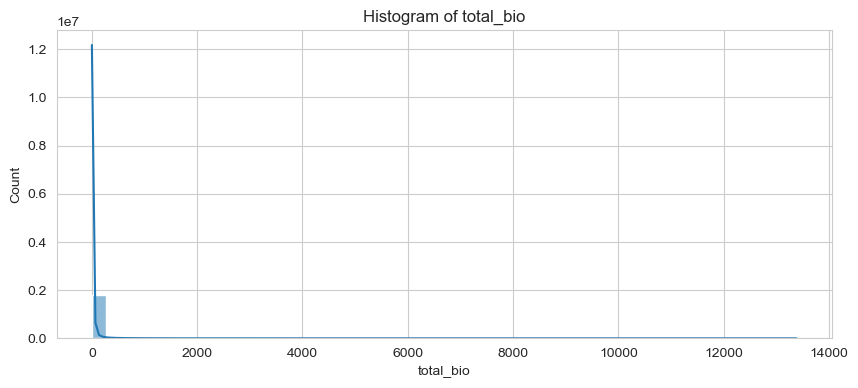

Outliers in total_bio


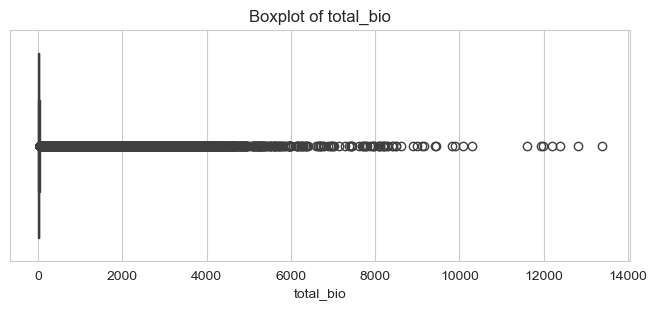

*******************************


In [64]:
numeric_cols = ['bio_age_5_17', 'bio_age_17_', 'total_bio']

for col in numeric_cols:
    print(f"\nDistribution of {col}")

    # Histogram
    plt.figure(figsize=(10,4))
    sns.histplot(biometric[col], kde=True, bins=50)
    plt.title(f"Histogram of {col}")
    plt.show()

    # Boxplot
    print(f"Outliers in {col}")

    plt.figure(figsize=(8,3))
    sns.boxplot(x=biometric[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

    print("*******************************")


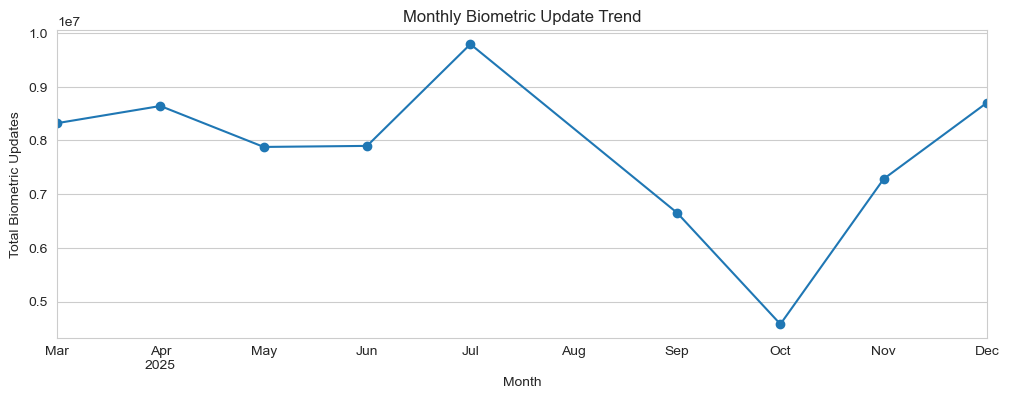

In [65]:
biometric['year_month'] = biometric['date'].dt.to_period('M')

monthly_bio = biometric.groupby('year_month')['total_bio'].sum()

plt.figure(figsize=(12,4))
monthly_bio.plot(marker='o')
plt.title("Monthly Biometric Update Trend")
plt.xlabel("Month")
plt.ylabel("Total Biometric Updates")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# total biometric updates
biometric['total_bio'] = biometric['bio_age_5_17'] + biometric['bio_age_17_']


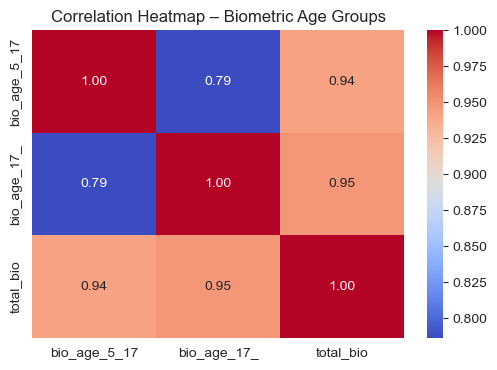

In [67]:
num_cols = ['bio_age_5_17', 'bio_age_17_', 'total_bio']

plt.figure(figsize=(6,4))
sns.heatmap(
    biometric[num_cols].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Heatmap – Biometric Age Groups")
plt.show()


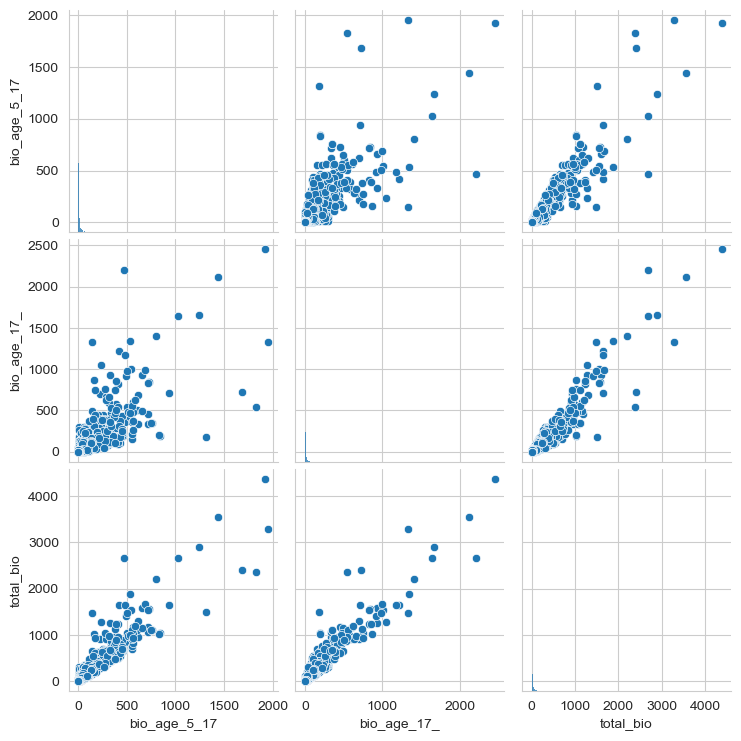

In [68]:
sample_df = biometric[num_cols].sample(10000, random_state=42)

sns.pairplot(sample_df)
plt.show()


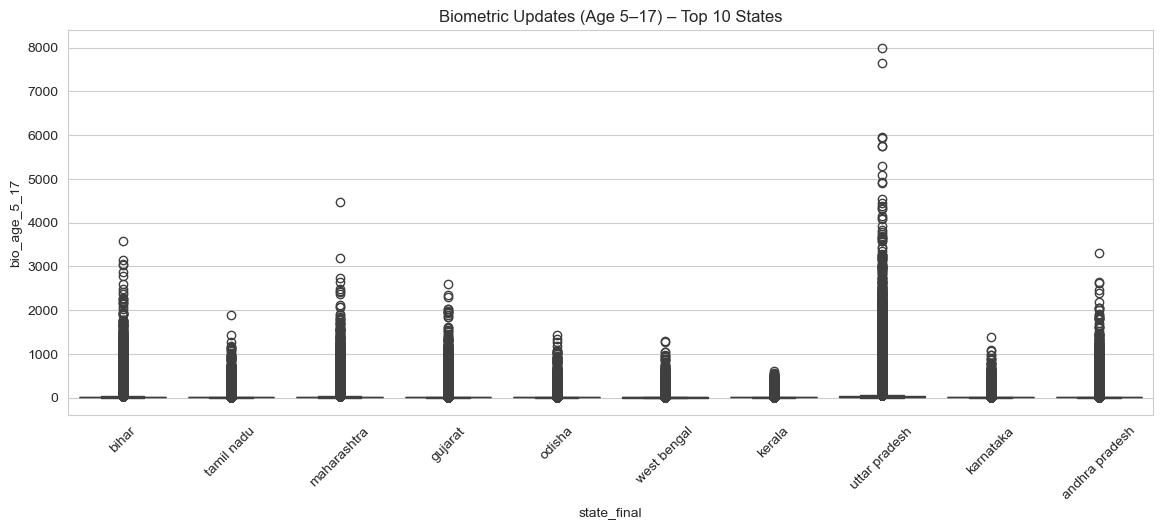

In [69]:
top_states = biometric['state_final'].value_counts().head(10).index

plt.figure(figsize=(14,5))
sns.boxplot(
    x='state_final',
    y='bio_age_5_17',
    data=biometric[biometric['state_final'].isin(top_states)]
)
plt.xticks(rotation=45)
plt.title("Biometric Updates (Age 5–17) – Top 10 States")
plt.show()


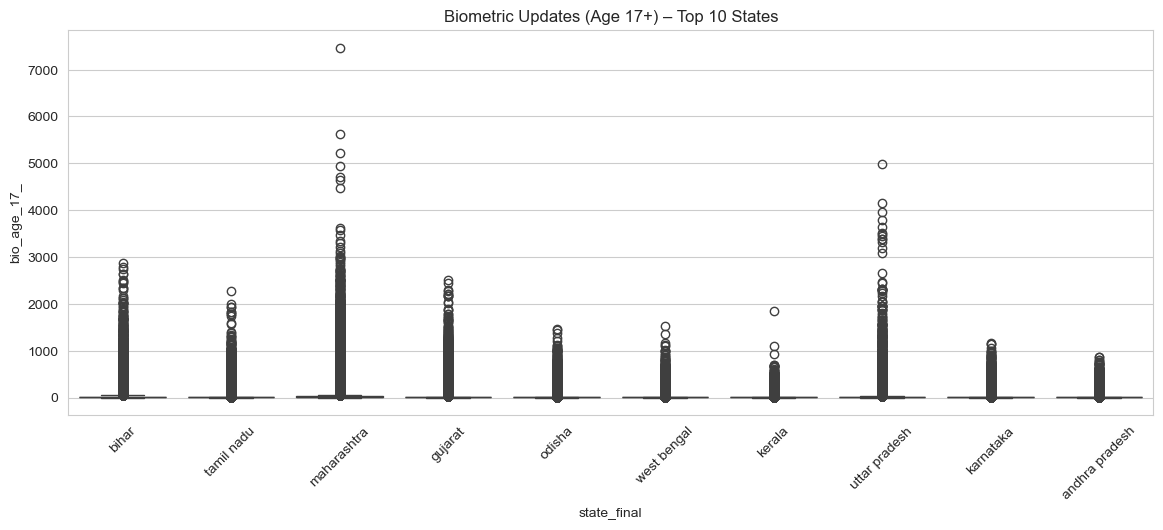

In [70]:
plt.figure(figsize=(14,5))
sns.boxplot(
    x='state_final',
    y='bio_age_17_',
    data=biometric[biometric['state_final'].isin(top_states)]
)
plt.xticks(rotation=45)
plt.title("Biometric Updates (Age 17+) – Top 10 States")
plt.show()


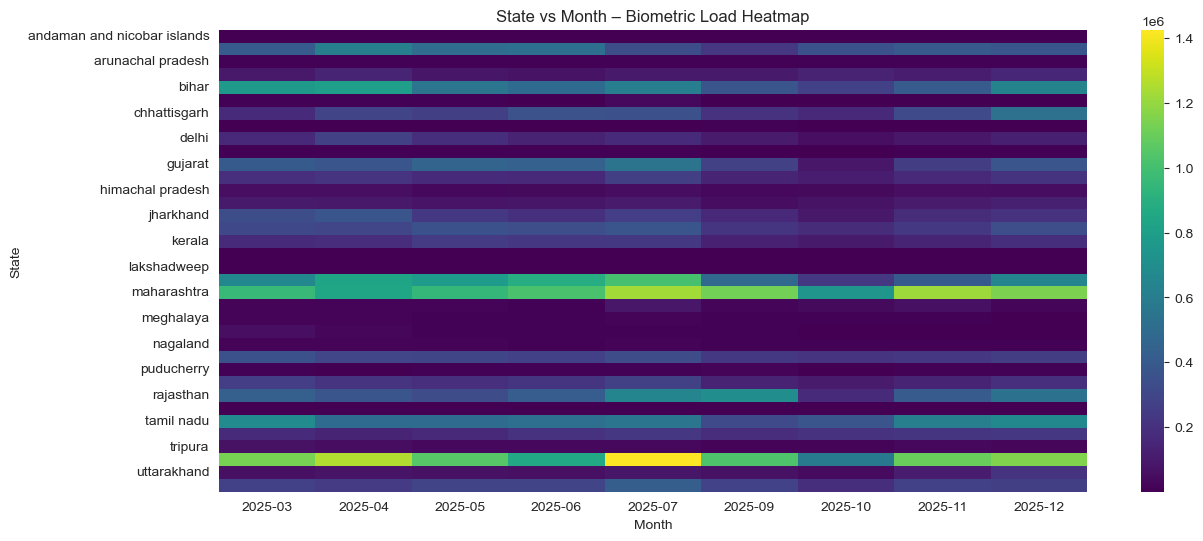

In [71]:
biometric['year_month'] = biometric['date'].dt.to_period('M')

state_month_ct = pd.crosstab(
    biometric['state_final'],
    biometric['year_month'],
    values=biometric['total_bio'],
    aggfunc='sum'
)

plt.figure(figsize=(14,6))
sns.heatmap(
    state_month_ct,
    cmap='viridis'
)
plt.title("State vs Month – Biometric Load Heatmap")
plt.xlabel("Month")
plt.ylabel("State")
plt.show()


Enter State (e.g. maharashtra):  maharashtra
Enter District (e.g. pune):  raigarh


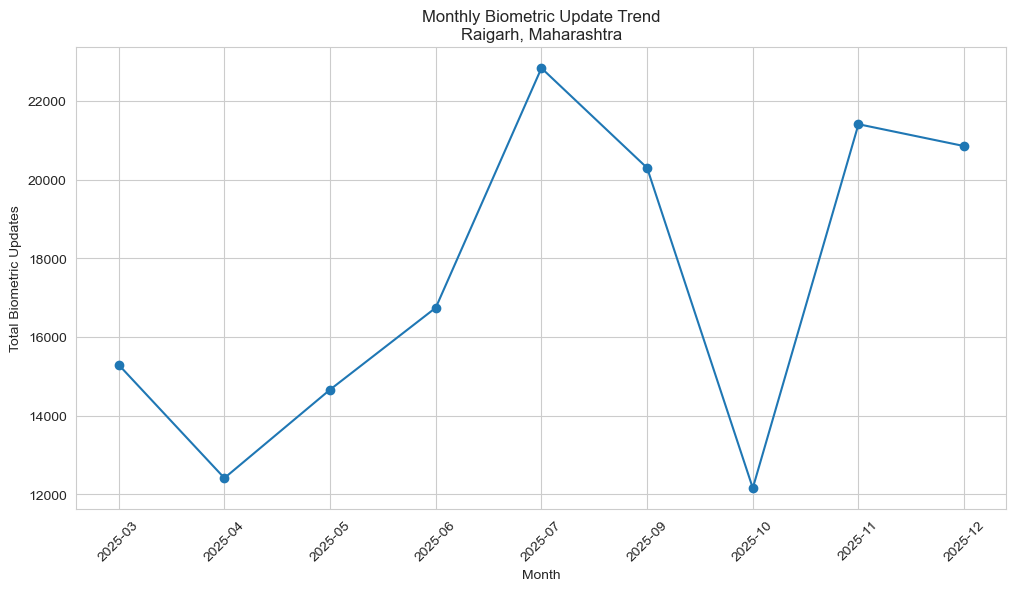

In [81]:
import pandas as pd
import matplotlib.pyplot as plt



# Ensure date format
biometric['date'] = pd.to_datetime(biometric['date'], dayfirst=True, errors='coerce')

# Create year-month
biometric['year_month'] = biometric['date'].dt.to_period('M')

# Total biometric updates
biometric['total_bio'] = biometric['bio_age_5_17'] + biometric['bio_age_17_']



selected_state = input("Enter State (e.g. maharashtra): ").strip().lower()
selected_district = input("Enter District (e.g. pune): ").strip().lower()



filtered_df = biometric[
    (biometric['state_final'].str.lower() == selected_state) &
    (biometric['district_final'].str.lower() == selected_district)
]

if filtered_df.empty:
    print("❌ No data found. Please check state/district spelling.")
else:

    
    monthly_data = (
        filtered_df
        .groupby('year_month')['total_bio']
        .sum()
        .reset_index()
    )

    monthly_data['year_month'] = monthly_data['year_month'].astype(str)

   
    plt.figure(figsize=(12,6))
    plt.plot(
        monthly_data['year_month'],
        monthly_data['total_bio'],
        marker='o'
    )

    plt.title(
        f"Monthly Biometric Update Trend\n"
        f"{selected_district.title()}, {selected_state.title()}"
    )
    plt.xlabel("Month")
    plt.ylabel("Total Biometric Updates")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
